# Evaluation


In [21]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

In [2]:
# Settings
ndb_eager_filepath = '/home/christopher/Workspace/statefun-ndb-benchmark/output-data/01-06-2022_12:55/ndb-eager-3-workers-embedded-10000.json'
ndb_lazy_filepath = '/home/christopher/Workspace/statefun-ndb-benchmark/output-data/01-06-2022_14:04/ndb-lazy-3-workers-embedded-10000.json'
rocksdb_filepath = '/home/christopher/Workspace/statefun-ndb-benchmark/output-data/01-06-2022_15:00/rocksdb-eager-3-workers-embedded-10000.json'
#rocksdb_full_filepath = '/media/farah/ce8e52bc-a47a-4fb7-b504-390efd9006ff/christopher/benchmark-data/17-05-2022_13:38/rocksdb-eager-3-workers-embedded-8000.json'

# rocksdb_filepath = ndb_filepath

In [3]:
# Preprocessing
ndb_eager_df = pd.read_json(ndb_eager_filepath, lines=True)

initial_timestamp = ndb_eager_df["inputKafkaTimestamp"].min()
ndb_eager_df["latency"] = ndb_eager_df["outputKafkaTimestamp"] - ndb_eager_df["inputKafkaTimestamp"]
# Start time of event in seconds, counted from initial event, convert to int to create 1 second buckets
ndb_eager_df["startTimeBucket"] = ((ndb_eager_df["inputKafkaTimestamp"] - initial_timestamp)/1000).astype(int)+8
ndb_eager_df["endTimeBucket"] = ((ndb_eager_df["outputKafkaTimestamp"] - initial_timestamp)/1000).astype(int)+8

ndb_lazy_df = pd.read_json(ndb_lazy_filepath, lines=True)

initial_timestamp = ndb_lazy_df["inputKafkaTimestamp"].min()
ndb_lazy_df["latency"] = ndb_lazy_df["outputKafkaTimestamp"] - ndb_lazy_df["inputKafkaTimestamp"]
# Start time of event in seconds, counted from initial event, convert to int to create 1 second buckets
ndb_lazy_df["startTimeBucket"] = ((ndb_lazy_df["inputKafkaTimestamp"] - initial_timestamp)/1000).astype(int)
ndb_lazy_df["endTimeBucket"] = ((ndb_lazy_df["outputKafkaTimestamp"] - initial_timestamp)/1000).astype(int)

rocksdb_df = pd.read_json(rocksdb_filepath, lines=True)

initial_timestamp = rocksdb_df["inputKafkaTimestamp"].min()
rocksdb_df["latency"] = rocksdb_df["outputKafkaTimestamp"] - rocksdb_df["inputKafkaTimestamp"]
# Start time of event in seconds, counted from initial event, convert to int to create 1 second buckets
rocksdb_df["startTimeBucket"] = ((rocksdb_df["inputKafkaTimestamp"] - initial_timestamp)/1000).astype(int)+2
rocksdb_df["endTimeBucket"] = ((rocksdb_df["outputKafkaTimestamp"] - initial_timestamp)/1000).astype(int)+2


In [50]:
pd.set_option('float_format', '{:f}'.format)
print("Latency averages:")
print("NDB EAGER: " + str(ndb_eager_df[ndb_eager_df["startTimeBucket"].between(10, 410)]["latency"].mean()))
print("NDB LAZY: " + str(ndb_lazy_df[ndb_lazy_df["startTimeBucket"].between(10, 410)]["latency"].mean()))
print("ROCKSDB INCREMENTAL: " + str(rocksdb_df[rocksdb_df["startTimeBucket"].between(10, 410)]["latency"].mean()))
#print("ROCKSDB FULL: " + str(rocksdb_full_df[rocksdb_full_df["startTimeBucket"] < 300]["latency"].mean()))

print("Throughput averages:")
print("NDB EAGER: " + str(len(ndb_eager_df[ndb_eager_df["startTimeBucket"].between(10, 410)].index)/400))
print("NDB LAZY: " + str(len(ndb_lazy_df[ndb_lazy_df["startTimeBucket"].between(10, 410)].index)/400))
print("ROCKSDB INCREMENTAL: " + str(len(rocksdb_df[rocksdb_df["startTimeBucket"].between(10, 410)].index)/400))
#print("ROCKSDB FULL: " + str(len(rocksdb_full_df[rocksdb_full_df["startTimeBucket"] < 300].index)/300))



Latency averages:
NDB EAGER: 313.77984186112997
NDB LAZY: 317.4606713673441
ROCKSDB INCREMENTAL: 209.19653288432835
Throughput averages:
NDB EAGER: 9059.4425
NDB LAZY: 9041.25
ROCKSDB INCREMENTAL: 9048.155


In [5]:
# Plot styling
plt.style.use('ggplot')

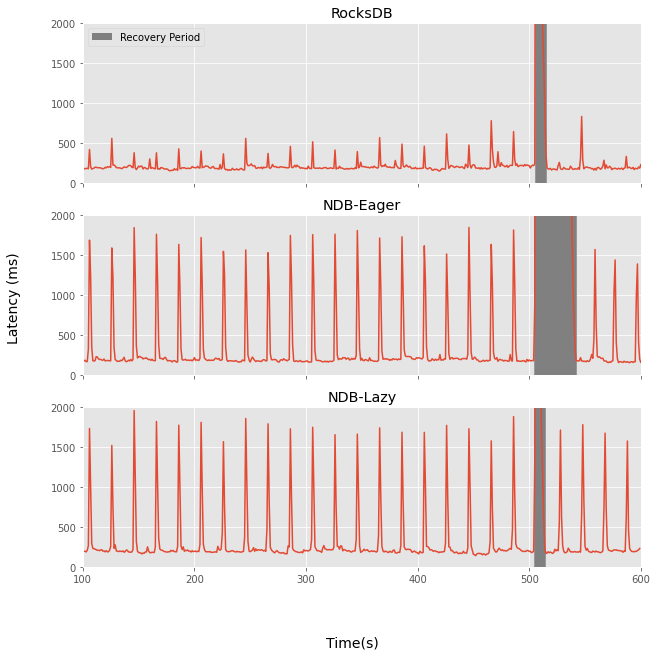

In [52]:
# Latency plot

# Set x limits from 0 to max to have plot span to the edges of the figure
ndb_max = ndb_eager_df["startTimeBucket"].max()
rocksdb_max = rocksdb_df["startTimeBucket"].max()
x_max = max(ndb_max, rocksdb_max)
#plt.xlim(0, x_max)
#plt.xlim(430, 490)
#plt.xticks(np.arange(0, x_max, 10.0))

#plt.xlim(450, 510)

fig, axs = plt.subplots(3, sharex=True, sharey=True)
fig.set_figheight(10)
fig.set_figwidth(10)
axs[0].legend([Patch(facecolor='gray',label='Recovery Period')], ["Recovery Period"])

fig.supylabel("Latency (ms)", size="14")
fig.supxlabel("Time(s)", size="14")

# RocksDB
p = rocksdb_df.groupby("startTimeBucket")["latency"].mean()
axs[0].plot(p, label="rocksdb")
axs[0].set_title("RocksDB")
axs[0].set_ylim(0, 2000)
axs[0].set_xlim(100, 600)
axs[0].axvspan(505, 515, color="grey")

# Eager Recover
p = ndb_eager_df.groupby("startTimeBucket")["latency"].mean()
axs[1].plot(p, label="ndb-eager")
axs[1].set_title("NDB-Eager")
axs[1].axvspan(504, 542, color="grey")

# Lazy Recovery
p = ndb_lazy_df.groupby("startTimeBucket")["latency"].mean()
axs[2].plot(p, label="ndb-lazy")
axs[2].set_title("NDB-Lazy")
axs[2].axvspan(504, 514, color="grey")


# Add line when failure happens
#plt.axvline(x=444, color="grey", dashes=(10.0, 10.0))

#p = rocksdb_full_df.groupby("startTimeBucket")["latency"].mean()
#plt.plot(p, label="rocksdb-full")

plt.savefig("/home/christopher/Workspace/statefun-ndb-benchmark/evaluator/figures/latency.svg")


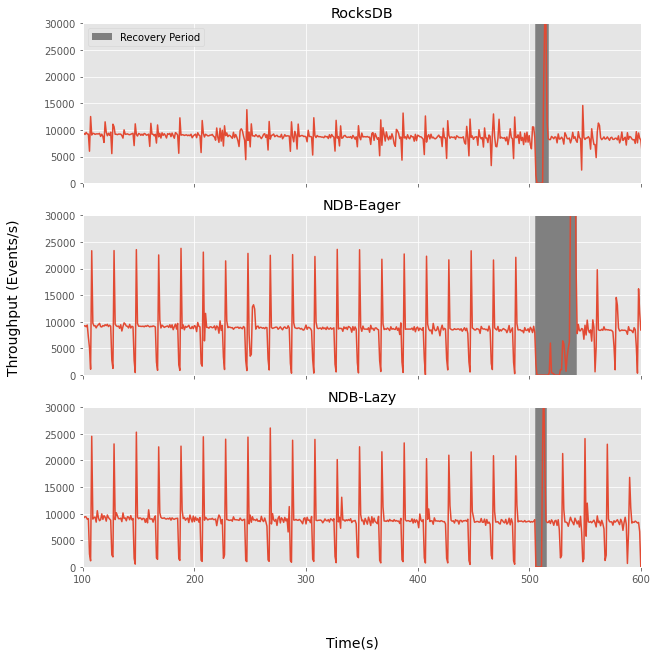

In [56]:
# Throughput plot

# Set x limits from 0 to max to have plot span to the edges of the figure
ndb_max = ndb_eager_df["endTimeBucket"].max()
rocksdb_max = rocksdb_df["endTimeBucket"].max()
x_max = max(ndb_max, rocksdb_max)

# Data plotting

fig, axs = plt.subplots(3, sharex=True, sharey=True)
fig.set_figheight(10)
fig.set_figwidth(10)
axs[0].legend([Patch(facecolor='gray',label='Recovery Period')], ["Recovery Period"])
fig.supylabel("Throughput (Events/s)", size="14")
fig.supxlabel("Time(s)", size="14")


p = rocksdb_df.groupby("endTimeBucket")["latency"].count()
p = p.reindex(range(0, x_max), fill_value=0)
axs[0].plot(p, label="rocksdb")
axs[0].set_title("RocksDB")
axs[0].axvspan(505, 517, color="grey")
axs[0].set_xlim(100, 600)
axs[0].set_ylim(0, 30000)

p = ndb_eager_df.groupby("endTimeBucket")["latency"].count()
p = p.reindex(range(0, x_max), fill_value=0)
axs[1].plot(p, label="ndb-eager")
axs[1].set_title("NDB-Eager")
axs[1].axvspan(505, 542, color="grey")

p = ndb_lazy_df.groupby("endTimeBucket")["latency"].count()
p = p.reindex(range(0, x_max), fill_value=0)
axs[2].plot(p, label="ndb-lazy")
axs[2].set_title("NDB-Lazy")
axs[2].axvspan(505, 515, color="grey")

#p = rocksdb_full_df.groupby("endTimeBucket")["latency"].count()
#p = p.reindex(range(0, x_max), fill_value=0)
#plt.plot(p, label="rocksdb-full")
plt.savefig("/home/christopher/Workspace/statefun-ndb-benchmark/evaluator/figures/throughput.svg")